### Define configuration files

In [1]:
from box.sim_box import SimulationBox
from potential.force import Force
from cell.cell import Cell
from substrate.substrates import Substrate
from helper_functions import helper_functions as hf
from visuals.figure import Figure
from polarity import polarity

import matplotlib.pyplot as plt
import glob
import pandas as pd
import numpy as np
import os
import time
from importlib import reload

reload(polarity)

from cell import cell

reload(cell)
from cell.cell import Cell


im_kwargs = {"origin": "lower", "extent": [0, 50, 0, 50]}
cntr_kwargs = {
    "origin": "lower",
    "extent": [0, 50, 0, 50],
    "colors": ["black"],
    "linewidths": [2],
    "levels": [0.5],
}


### Some random functions

In [2]:
def _masked(arr, masker):
    arr_masked = np.ones(arr.shape) * np.nan
    i, j = np.where(masker >= 0.5)
    arr_masked[i, j] = arr[i, j]
    return arr_masked


def plot_probs(cell, p1, p2, p, c, time, p_ratio):
    cntr = cell.contour[0][:, ::-1]

    if not isinstance(p1, np.ndarray):
        p1 = np.array([p1] * cntr.shape[0])

    if not isinstance(p2, np.ndarray):
        p2 = np.array([p2] * cntr.shape[0])

    plt.figure(figsize=(6, 6))
    plt.subplot(221)
    plt.title("filopodia")
    plt.scatter(cntr[:, 0], cntr[:, 1], c=p1, cmap="coolwarm")
    plt.colorbar()

    plt.subplot(222)
    plt.title("feedback")
    plt.scatter(cntr[:, 0], cntr[:, 1], c=p2, cmap="coolwarm")
    plt.colorbar()
    plt.scatter(*c, color="black", s=20)

    plt.subplot(223)
    plt.title("total")
    plt.scatter(cntr[:, 0], cntr[:, 1], c=p, cmap="coolwarm")
    plt.colorbar()

    plt.subplot(224)
    plt.title("Tension")
    plt.plot(time, p_ratio)
    plt.xlabel("Time")
    plt.ylabel(r"$P/P_0$")

    plt.subplots_adjust(wspace=1, hspace=0.7)
    plt.show()

### Initialize system

In [3]:
def _build_system(simbox, cell_config, cell_rng_seed):
    # unpack
    N_mesh, L_box = simbox.N_mesh, simbox.L_box

    # define base substrate
    sub_config = simbox.sub_config
    sub_dim = simbox.sub_config["sub_sep"]
    xi = sub_config["xi"]
    kind = sub_config["kind"]
    # buffer = sub_config["buffer"]
    sub = Substrate(N_mesh, L_box, xi)
    if kind == "two-state":
        chi = sub.two_state_sub(bridge_width=17, delta_centers=sub_dim)
    elif kind == "rectangular":
        # chi = sub.rectangular(width=150, length=150)
        chi = sub.rectangular()

    else:
        raise ValueError(f"{kind} for substrate is not understood.")

    # initialize cells
    # set the cumulative substrate they will interact with
    cell = Cell(cell_config[0], simbox, cell_rng_seed)
    cell.W = 0.5 * cell.g * chi

    return cell, chi


def _define_paths(gid):
    SIMBOX_CONFIG = f"../configs/IM/grid_id{gid}/simbox.yaml"
    ENERGY_CONFIG = "../configs/energy.yaml"

    CELL_CONFIG = [f"../configs/IM/grid_id{gid}/cell.yaml"]

    return dict(
        simbox=SIMBOX_CONFIG,
        energy=ENERGY_CONFIG,
        cell=CELL_CONFIG,
    )


def _mvg_generator(cell):
    import numpy as np
    from polarity.mvgaussian import MVGaussian

    N_mesh = cell.simbox.N_mesh
    d = np.arange(0, N_mesh, 1)
    # d = np.linspace(0, N_mesh, N_mesh)
    x, y = np.meshgrid(d, d)
    X = np.array(list(zip(x.flatten(), y.flatten())))

    cell.mvg_gen = MVGaussian(X)

In [4]:
# define various paths
gid = 161
paths = _define_paths(gid)

# initialize the simulation box
simbox = SimulationBox(paths["simbox"])
seed = int(time.time())
seed = 8197
cell, chi = _build_system(simbox, paths["cell"], cell_rng_seed=seed)

# initialize the force calculator
force_calculator = Force(paths["energy"])

# noise patch -- init MVG generator for the cell
_mvg_generator(cell)

### Evolve the cell

In [5]:
print(cell._prob_type)
print(np.array(cell.cm[1]) * 6)
print(cell._rng_type)


none
[182.05861169 150.        ]
RandomState


In [6]:
def motility_force(cell, grad_phi, mp, n):
    norm_grad_phi = np.sqrt(np.sum(grad_phi * grad_phi, axis=0))
    n_field = -1 * grad_phi / (norm_grad_phi + 1e-10)
    phi = cell.phi
    # p_field = cell.p_field
    # fx_motil = cell.alpha * p_field * phi**2 * (1 - phi) ** 2 * (1 - mp) * n_field[0]
    # fy_motil = cell.alpha * p_field * phi**2 * (1 - phi) ** 2 * (1 - mp) * n_field[1]

    # fx_motil = cell.alpha * p_field * phi**2 * (1 - phi) ** 2 * n_field[0]
    # fy_motil = cell.alpha * p_field * phi**2 * (1 - phi) ** 2 * n_field[1]

    tau_add = hf._poisson_add_time(cell.rng, cell.pol_model_kwargs["add_rate"])
    mvg_patch = 0

    if n % tau_add == 0:
        mag = cell.rng.normal(
            loc=cell.pol_model_kwargs["mag_mean"],
            scale=cell.pol_model_kwargs["mag_std"],
        )

        c = cell.contour[0][:, ::-1]
        c = c[cell.rng.choice(range(c.shape[0]))]
        cov_ii = 20
        cov_ij = 0
        cov = np.array([[cov_ii, cov_ij], [cov_ij, cov_ii]])
        N_mesh = cell.simbox.N_mesh
        mvg_patch = cell.mvg_gen.pdf(c, cov).reshape(N_mesh, N_mesh)
        mvg_patch *= mag

    fx_motil = (
        cell.alpha * mvg_patch * phi**2 * (1 - phi) ** 2 * (1 - mp) * n_field[0]
    )
    fy_motil = (
        cell.alpha * mvg_patch * phi**2 * (1 - phi) ** 2 * (1 - mp) * n_field[1]
    )

    return fx_motil, fy_motil


# Focus on MVG

In [7]:
def plot_mvg_diff(mvg1, mvg2, savepath=None):
    plt.figure(figsize=(12, 3), dpi=200)
    plt.subplot(131)
    plt.title("Mine")
    plt.imshow(mvg1, origin="lower")
    plt.colorbar()
    plt.xlim((75, 125))
    plt.ylim((75, 125))

    plt.subplot(132)
    plt.title("Scipy")
    plt.imshow(mvg2, origin="lower")
    plt.colorbar()
    plt.xlim((75, 125))
    plt.ylim((75, 125))

    plt.subplot(133)
    plt.title("Mine - Scipy")
    plt.imshow(mvg1 - mvg2, origin="lower")
    plt.colorbar()
    plt.xlim((75, 125))
    plt.ylim((75, 125))

    plt.subplots_adjust(wspace=0.5)

    if savepath is not None:
        plt.savefig(savepath)
        plt.close()
    else:
        plt.show()


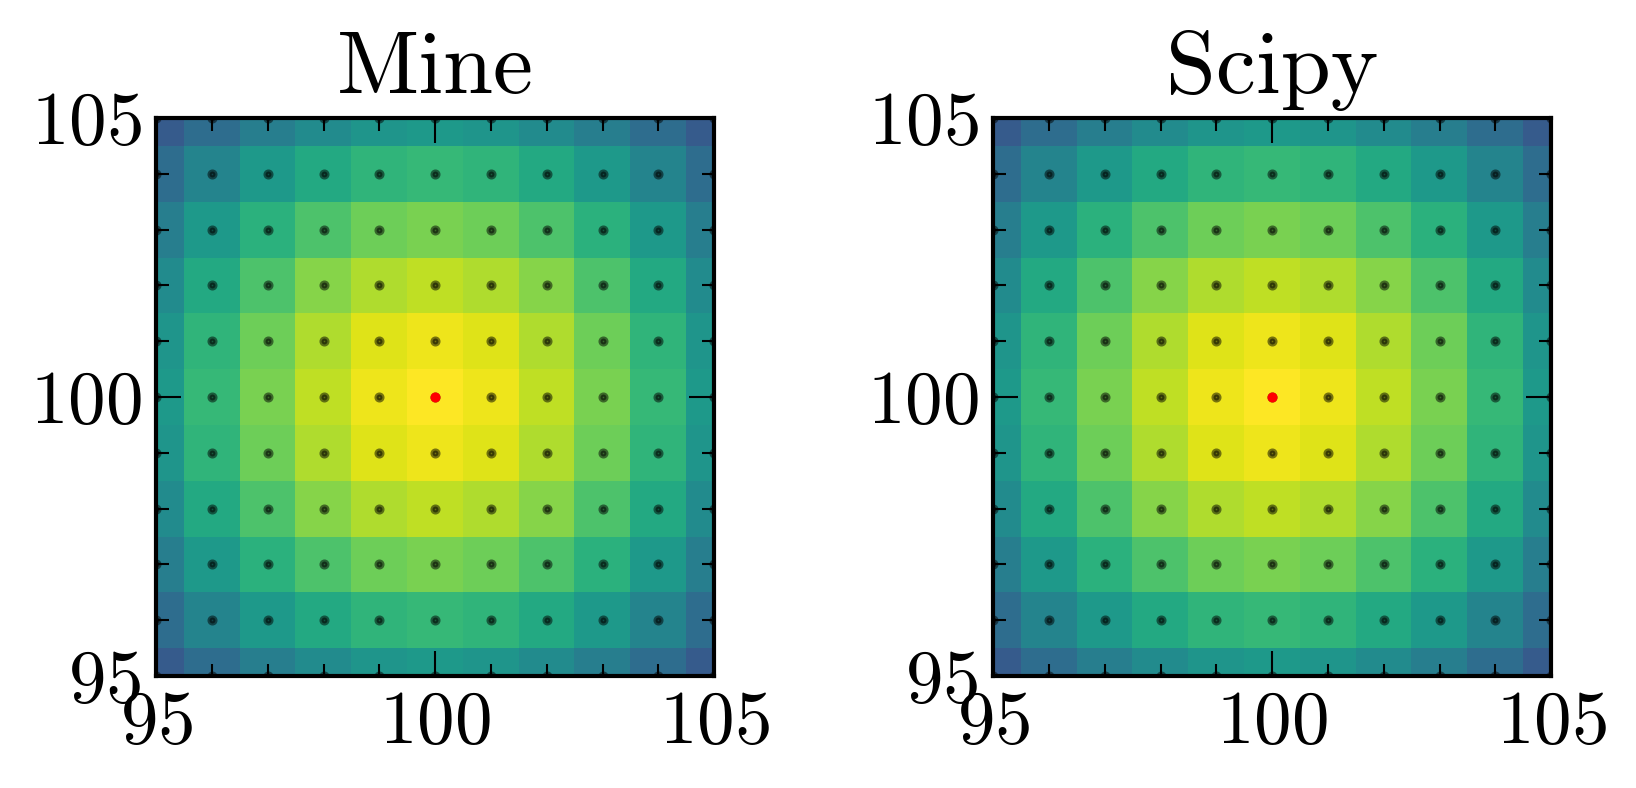

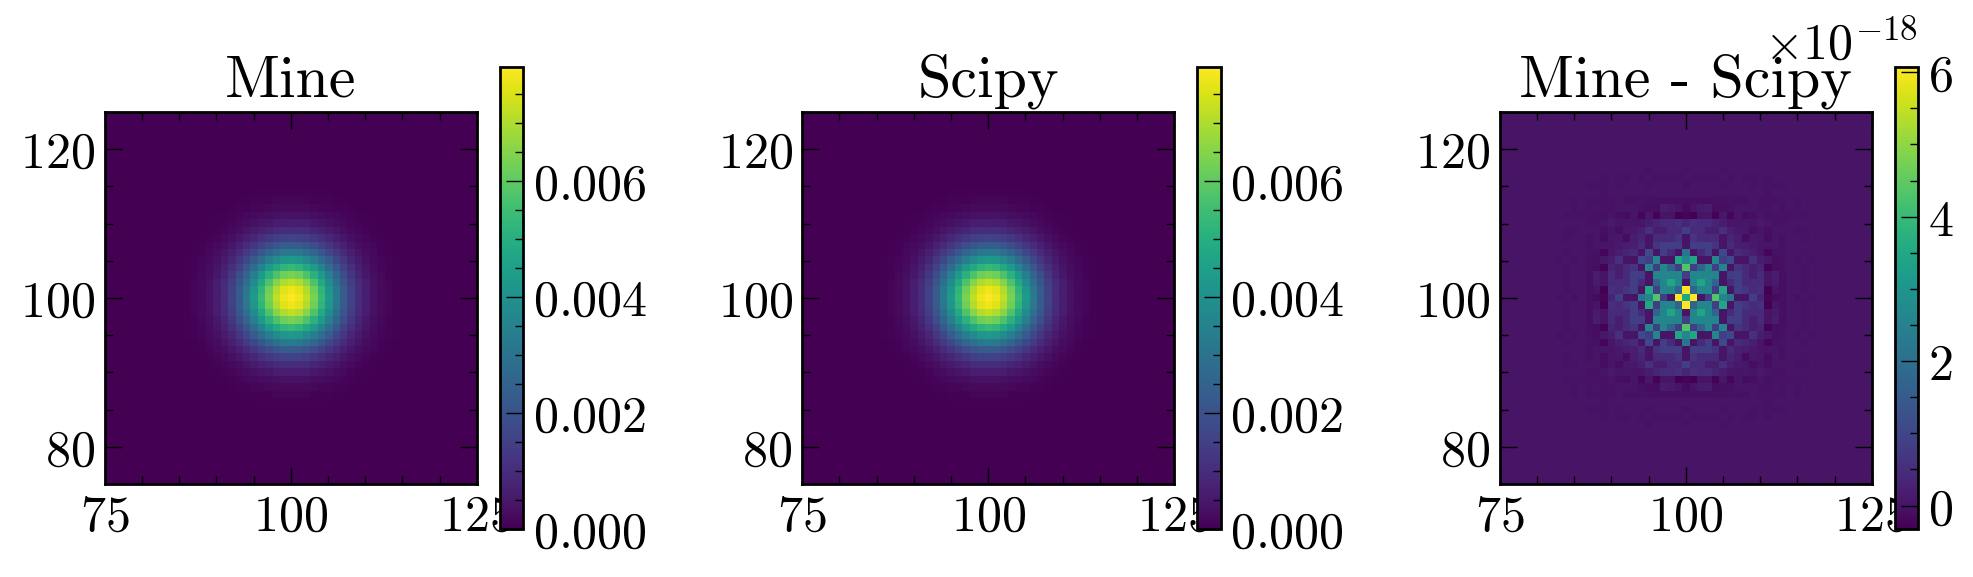

In [8]:
from scipy.stats import multivariate_normal
from polarity.mvgaussian import MVGaussian

cov_ii = 20
cov_ij = 0
cov = np.array([[cov_ii, cov_ij], [cov_ij, cov_ii]])
mean = np.array([100, 100])
N_mesh = cell.simbox.N_mesh
mvg_patch = cell.mvg_gen.pdf(mean, cov).reshape(N_mesh, N_mesh)

x = np.arange(cell.simbox.N_mesh)
x, y = np.meshgrid(x, x)
X = np.dstack((x, y)).reshape(-1, 2)
scipy_mvg = multivariate_normal(mean, cov=cov).pdf(X).reshape(N_mesh, N_mesh)

plt.figure(figsize=(6, 3), dpi=300)

plt.subplot(121)
plt.title("Mine")
plt.imshow(mvg_patch, origin="lower")
plt.scatter(X[:, 0], X[:, 1], s=2, alpha=0.5, color="black")
plt.scatter(100, 100, color="red", s=2)
plt.xlim((95, 105))
plt.ylim((95, 105))

plt.subplot(122)
plt.title("Scipy")
plt.imshow(scipy_mvg, origin="lower")
plt.scatter(X[:, 0], X[:, 1], s=2, alpha=0.5, color="black")
plt.scatter(100, 100, color="red", s=2)
plt.xlim((95, 105))
plt.ylim((95, 105))

plt.subplots_adjust(wspace=0.5)
plt.show()

plot_mvg_diff(mvg_patch, scipy_mvg)


In [9]:
from IPython import display
import os

t = []
p_ratio = []

p_fields = []
vx_fields = []
vy_fields = []

cms = pd.DataFrame([])
save_path = f"../output/IM/grid_id{gid}/run_0/visuals/"

N = cell.simbox.sim_time
n_stat = cell.simbox.n_stats
n_view = cell.simbox.n_view

if not os.path.exists(save_path):
    os.makedirs(save_path)

for n in range(N):
    grad_x, grad_y, _ = hf.compute_gradients(cell.phi, cell.simbox.dx)
    grad_phi = np.array([grad_x, grad_y])
    eta = cell.eta

    if n % n_stat == 0:
        print(np.array(cell.cm[1]) * 6)

        p_fields.append(cell.p_field)
        vx_fields.append(cell.vx)
        vy_fields.append(cell.vy)

        t = n * cell.simbox.dt * 8 / 60  # t in hr
        cms = pd.concat(
            [
                cms,
                pd.DataFrame(
                    [[*cell.cm[1], *cell.v_cm, t]],
                    columns=["x", "y", "vx", "vy", "time[hr]"],
                ),
            ]
        )

    # update polarization field
    tau_add = hf._poisson_add_time(cell.rng, cell.pol_model_kwargs["add_rate"])
    mvg_patch = 0
    c = [-1]

    if n % tau_add == 0:
        # cell.rng = np.random.RandomState(seed=n)

        mag = cell.rng.normal(
            loc=cell.pol_model_kwargs["mag_mean"],
            scale=cell.pol_model_kwargs["mag_std"],
        )

        c = cell.contour[0][:, ::-1]
        c = c[cell.rng.choice(range(c.shape[0]))]
        cov_ii = 20
        cov_ij = 0
        cov = np.array([[cov_ii, cov_ij], [cov_ij, cov_ii]])
        N_mesh = cell.simbox.N_mesh
        mvg_patch = cell.mvg_gen.pdf(c, cov).reshape(N_mesh, N_mesh)
        mvg_patch *= mag

        # D = 0.5
        # mvg_patch += np.sqrt(
        #     4 * D**2 * cell.simbox.dt / cell.simbox.dx**2
        # ) * np.random.randn(*mvg_patch.shape)

    # polarization field (n+1)
    p_field_next = polarity.update_field(cell, chi, mvg_patch, cell.pol_model_kwargs)

    # phi_(n+1)
    phi_i_next, dF_dphi = hf._update_field(cell, grad_phi, force_calculator)

    # compute motility forces at time n
    fx_motil, fy_motil = force_calculator.cyto_motility_force(cell, grad_phi, chi)
    # fx_motil, fy_motil = motility_force(cell, grad_phi, chi, n)

    # compute thermodynamic forces at time n
    fx_thermo = dF_dphi * grad_x
    fy_thermo = dF_dphi * grad_y

    # view shit before updating
    if n % n_view == 0:
        Figure.view_pol_field(
            cell,
            chi,
            dpi=150,
            path=save_path + f"img_{n//n_view}.png",
        )

    # fig, axs = plt.subplots(3, 3, figsize=(9, 6), dpi=200)

    # axs[0, 0].contour(cell.phi, levels=[0.5], colors=["black"], **im_kwargs)
    # axs[0, 0].contour(chi, levels=[0.5], colors=["black"], **im_kwargs)
    # axs[0, 0].imshow(_masked(cell.p_field, cell.phi), cmap="coolwarm", **im_kwargs)

    # if len(c) == 2:
    #     axs[0, 1].set_title(f"MVG patch\nmag = {mag:.0f}", fontsize=12)
    #     axs[0, 1].imshow(
    #         cell.mvg_gen.pdf(c, cov).reshape(N_mesh, N_mesh),
    #         cmap="cividis",
    #         **im_kwargs,
    #     )
    #     axs[0, 1].contour(
    #         cell.phi, levels=[0.5], colors=["white"], linewidths=[1], **im_kwargs
    #     )
    #     axs[0, 1].scatter(*(c * cell.simbox.dx), zorder=4, color="red", s=5)

    # axs[0, 2].set_title("P(t+dt) - P(t)", fontsize=14)
    # axs[0, 2].imshow(
    #     p_field_next - cell.p_field,
    #     cmap="cividis",
    #     **im_kwargs,
    # )
    # axs[0, 2].contour(
    #     cell.phi, levels=[0.5], colors=["white"], linewidths=[1], **im_kwargs
    # )

    # axs[1, 0].set_title("fx_thermo", fontsize=14)
    # axs[1, 0].imshow(
    #     fx_thermo,
    #     cmap="cividis",
    #     **im_kwargs,
    # )
    # axs[1, 0].contour(
    #     cell.phi, levels=[0.5], colors=["white"], linewidths=[1], **im_kwargs
    # )

    # axs[1, 1].set_title("fx_motil", fontsize=14)
    # axs[1, 1].imshow(
    #     fx_motil,
    #     cmap="cividis",
    #     **im_kwargs,
    # )
    # axs[1, 1].contour(
    #     cell.phi, levels=[0.5], colors=["white"], linewidths=[1], **im_kwargs
    # )

    # axs[1, 2].set_title("vx", fontsize=14)
    # axs[1, 2].imshow(
    #     cell.vx,
    #     cmap="cividis",
    #     **im_kwargs,
    # )
    # axs[1, 2].contour(
    #     cell.phi, levels=[0.5], colors=["white"], linewidths=[1], **im_kwargs
    # )

    # axs[2, 0].set_title("fy_thermo", fontsize=14)
    # axs[2, 0].imshow(
    #     fy_thermo,
    #     cmap="cividis",
    #     **im_kwargs,
    # )
    # axs[2, 0].contour(
    #     cell.phi, levels=[0.5], colors=["white"], linewidths=[1], **im_kwargs
    # )

    # axs[2, 1].set_title("fy_motil", fontsize=14)
    # axs[2, 1].imshow(
    #     fy_motil,
    #     cmap="cividis",
    #     **im_kwargs,
    # )
    # axs[2, 1].contour(
    #     cell.phi, levels=[0.5], colors=["white"], linewidths=[1], **im_kwargs
    # )

    # axs[2, 2].set_title("vy", fontsize=14)
    # axs[2, 2].imshow(
    #     cell.vy,
    #     cmap="cividis",
    #     **im_kwargs,
    # )
    # axs[2, 2].contour(
    #     cell.phi, levels=[0.5], colors=["white"], linewidths=[1], **im_kwargs
    # )

    # plt.setp(axs, xlim=(15, 35), ylim=(20, 30))
    # plt.subplots_adjust(wspace=0.5)
    # plt.savefig(save_path + f"img_{n}.png")
    # plt.close()

    # UPDATE class variables now
    cell.phi = phi_i_next
    cell.p_field = p_field_next
    cell.contour = hf.find_contour(cell.phi, interpolate=cell._cntr_interp)
    cell.cm = hf.compute_CM(cell)
    cell.v_cm = hf.compute_v_CM(cell)
    cell.vx = (fx_thermo + fx_motil) / eta
    cell.vy = (fy_thermo + fy_motil) / eta

    # cell.vx = (fx_thermo) / eta
    # cell.vy = (fy_thermo) / eta

[182.05861169 150.        ]
[183.29391987 148.66636242]
[185.5674659  146.91333195]
[185.2272856  146.39418455]
[184.60622769 146.86617975]
[184.06502227 146.9914509 ]
[184.21417086 146.28555068]
[183.37016338 145.66611324]
[183.45962279 145.34253462]
[184.38059282 146.40979697]
[185.3093587  147.84994144]
[184.79895018 148.58029424]
[183.55405509 148.88200721]
[183.57046397 149.58837274]
[183.52406319 150.45015113]
[183.31523137 150.73706997]
[182.87904065 150.59721611]
[182.39563626 150.06718768]
[183.56197421 149.82882222]
[186.04589984 147.64120213]
[187.395293   146.27159153]
[187.77135228 145.0913676 ]
[187.61748412 145.35475198]
[186.98900017 145.42425112]
[186.37805585 144.62169652]
[186.66447013 145.91779549]
[187.04413234 146.58190521]
[187.04362138 146.7100614 ]
[185.80488968 147.15434634]
[186.35961866 148.42744856]
[185.76677893 148.785742  ]
[185.04202697 149.30629208]
[183.81467754 149.2593815 ]
[182.98267503 149.55957155]
[182.0412135  148.94847988]
[181.49639722 147.64

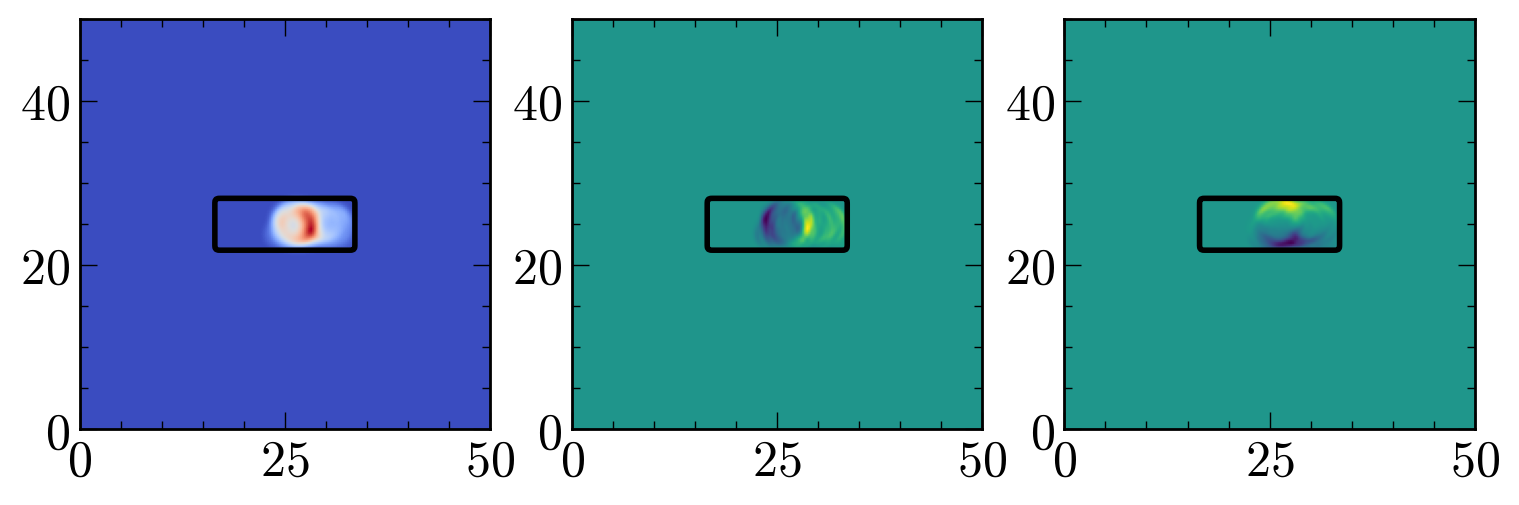

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), dpi=200)
axs[0].contour(chi, levels=[0.5], colors=["black"], **im_kwargs)
axs[0].imshow(np.mean(p_fields, axis=0), cmap="coolwarm", **im_kwargs)

axs[1].contour(chi, levels=[0.5], colors=["black"], **im_kwargs)
axs[1].imshow(np.mean(vx_fields, axis=0), **im_kwargs)

axs[2].contour(chi, levels=[0.5], colors=["black"], **im_kwargs)
axs[2].imshow(np.mean(vy_fields, axis=0), **im_kwargs)
plt.show()


In [11]:
def cm(f, N_mesh, dx):
    x = np.arange(0, N_mesh, 1)
    xg, yg = np.meshgrid(x, x)
    cm_x, cm_y = np.sum(xg * f), np.sum(yg * f)
    norm = np.sum(f)

    return np.array([cm_x / norm, cm_y / norm]) * dx


f = p_fields[0]
cm(f, cell.simbox.N_mesh, cell.simbox.dx)

array([30.35754058, 24.9700484 ])

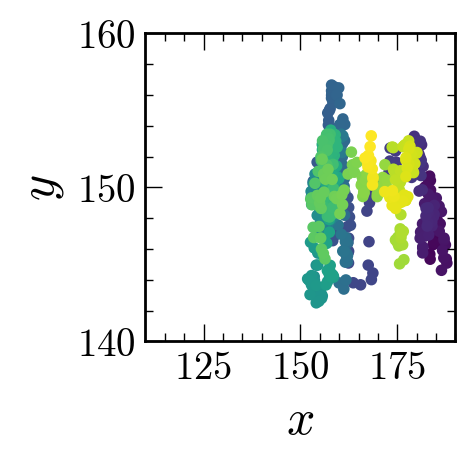

In [12]:
plt.figure(figsize=(2, 2), dpi=200)
plt.scatter(cms.x * 6, cms.y * 6, c=cms.reset_index().index, s=10)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.tick_params(axis="both", which="major", labelsize=14)
plt.tick_params(axis="both", which="minor", labelsize=12)
plt.xlim((110, 190))
plt.ylim((140, 160))
plt.show()

Documenting shit

- Focusing on Grid ID 81 with the proper seed
   - I changed `cov_ii` from 20 to 5 -> cell jumped to the left side 2X as fast, and spent the remaining 3/4 of its sim time hanging on the left
   
   - Try `cov_ii` = 50 or larger to make the cell remain circular. Collect stats and the various fields. Look at asymmetries
   
   - In dP/dt: MVG * phi -> MVG no bueno either

In [13]:
cntr = cell.contour[0][:, ::-1] * cell.simbox.dx
np.sqrt(np.sum(np.diff(cntr, axis=0) ** 2, axis=1)).sum()

16.924816447175704

In [14]:
2 * np.pi * 4.5


28.274333882308138

In [15]:
import sys

sys.exit(1)

SystemExit: 1

/home/pedrom/miniconda3/envs/hopper/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3513: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
c = cell.contour[0][:, ::-1]
c = c[cell.rng.choice(range(c.shape[0]))]
cov_ii = 10
cov_ij = 0
cov = np.array([[cov_ii, cov_ij], [cov_ij, cov_ii]])
N_mesh = cell.simbox.N_mesh

plt.imshow(cell.mvg_gen.pdf(c, cov).reshape(N_mesh, N_mesh))
plt.contour(cell.phi, levels=[0.5], colors=["white"], linewidths=[3])
plt.scatter(*c, zorder=5)
plt.xlim((70, 110))
plt.ylim((85, 115))


# full thing

In [ ]:
from IPython import display
import os

t = []
p_ratio = []
save_path = f"../output/IM/grid_id{gid}/run_0/visuals/"

N = 0
cap = 250

if not os.path.exists(save_path):
    os.makedirs(save_path)

for n in range(N):
    grad_x, grad_y, _ = hf.compute_gradients(cell.phi, cell.simbox.dx)
    grad_phi = np.array([grad_x, grad_y])
    eta = cell.eta

    if cell.pol_model_kwargs["_pixel_noise"]:
        p_field_next = cell.p_field + polarity.pixel_random_noise(cell, D=0.2)
    else:
        # contour PMF to add mvg patch
        p1 = polarity.cntr_probs_filopodia(cell, grad_phi, chi, delta_l=4)
        p2 = polarity.cntr_probs_feedback(
            cell, grad_phi, delta_l=cell.pol_model_kwargs["_go_in"]
        )
        if cell._prob_type == "p1":
            cntr_probs = p1
        elif cell._prob_type == "p2":
            cntr_probs = p2
        elif cell._prob_type == "none":
            cntr_probs = None
        else:
            cntr_probs = p1 * p2
            cntr_probs /= cntr_probs.sum()

        # add MVG patch according to a Poisson process
        tau_add = hf._poisson_add_time(cell.rng, cell.pol_model_kwargs["add_rate"])
        picked_c = [np.nan, np.nan]
        mag = 0

        if n % tau_add == 0:
            mag = cell.rng.normal(
                loc=cell.pol_model_kwargs["mag_mean"],
                scale=cell.pol_model_kwargs["mag_std"],
            )
            mvg_patch, picked_c = polarity.mvg_patch(cell, cntr_probs)
            mvg_patch *= mag

        else:
            mvg_patch = 0

        # polarization field (n+1)
        p_field_next = polarity.update_field(
            cell, chi, mvg_patch, cell.pol_model_kwargs
        )

    # phi_(n+1)
    phi_i_next, dF_dphi = hf._update_field(cell, grad_phi, force_calculator)

    if n % cap == 0:
        # display.clear_output(wait=True)
        # t.append(n)
        # cntr = cell.contour[0][:, ::-1] * cell.simbox.dx
        # perim = np.sqrt(np.sum(np.diff(cntr, axis=0) ** 2, axis=1)).sum()
        # p_ratio.append(perim / (2 * np.pi * 4.5))

        # plot_probs(cell, p1, p2, cntr_probs, picked_c, t, p_ratio)
        print(np.array(cell.cm[1]) * 6)

        Figure.view_pol_field(
            cell,
            chi,
            dpi=150,
            path=save_path + f"img_{n//cap}.png",
        )

    # compute motility forces at time n
    fx_motil, fy_motil = force_calculator.cyto_motility_force(cell, grad_phi, chi)

    # compute thermodynamic forces at time n
    fx_thermo = dF_dphi * grad_x
    fy_thermo = dF_dphi * grad_y

    # UPDATE class variables now
    cell.phi = phi_i_next
    cell.p_field = p_field_next
    cell.contour = hf.find_contour(cell.phi, interpolate=cell._cntr_interp)
    cell.cm = hf.compute_CM(cell)
    cell.v_cm = hf.compute_v_CM(cell)
    cell.vx = (fx_thermo + fx_motil) / eta
    cell.vy = (fy_thermo + fy_motil) / eta
